# Create an interactive molecular attention plot

 https://paccmann.github.io/assets/tox21_attention_maps

![ChessUrl](../assets/attention.gif "toxicophore attention")

In [ ]:
! pip install matplotlib pandas mpld3

In [1]:
import statistics

import mpld3
from mpld3 import plugins
from mpld3 import fig_to_html
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D

mpld3.enable_notebook()

### Setup some variables and plotting routines


In [2]:
NON_ATOM_CHARACTERS = set(
    list(map(str, range(1, 10))) + list('%{}'.format(index) for index in range(10, 30)) + ['/','\\','(', ')', '#', '=', '.', ':']
)
CMAP = cm.Reds
CMAP_TOXICOPHORES = cm.Blues
COLOR_NORMALIZERS = {
    'linear': colors.Normalize,
    'logarithmic': colors.LogNorm
}
COLOR_NORMALIZATION = 'logarithmic'





COLOR_NORMALIZERS = {
    'linear': colors.Normalize,
    'logarithmic': colors.LogNorm
}
NON_ATOM_CHARACTERS = set(
    list(map(str, range(1, 10))) + list('%{}'.format(index) for index in range(10, 30)) + ['/','-','\\','(', ')', '#', '=', '.', ':']
)
SVG_WIDTH = 400
SVG_HEIGHT = 200
ATOM_RADII = 0.5
CMAP = cm.Reds
CMAP_TOXICOPHORES = cm.Blues
PADDING_ATOM = '<PAD>'
CMAP = cm.Oranges # Reds
CMAP_TOXICOPHORES = cm.Greens # Blues
COLOR_NORMALIZERS = {
    'linear': colors.Normalize,
    'logarithmic': colors.LogNorm
}
COLOR_NORMALIZATION = 'logarithmic'



NON_ATOM_CHARACTERS = set(
    list(map(str, range(1, 10))) + list('%{}'.format(index) for index in range(10, 30)) + ['/','\\','(', ')', '#', '=', '.', ':']
)

def _get_index_and_colors(smi_att, smi_token, indexes, indexes_toxic, color_mapper_non_toxic, color_mapper_toxic):
    """
    Get index and RGB colors from a color map using a rule.
    The predicate acts on a tuple of (value, object).
    """
    
    # for atoms in not_tox_location
    indices = []
    colors = {}
    attention = {}
    for index, attention in enumerate(
        map(
            lambda t: t[0],
            filter(
                lambda t: indexes(t),
                zip(smi_att, smi_token)
            )
        )
    ):
        indices.append(index)
        if index in indexes_toxic:
            colors[index] = color_mapper_toxic.to_rgba(attention)
        else:
            colors[index] = color_mapper_non_toxic.to_rgba(attention)
    return colors


### Read in the data
This assumes that the data file comes in a processed format. To redo this plot on your own data you will need a .csv with one molecule per row. For each row, you should have the following
- `molecule_smi`: The SMILES string of the molecules
- `smiles_token`: A list of SMILES tokens for which you have the attention, e.g., ['O', 'C', ...]
- `smiles_attention`: A list of floats with the attention for each SMILES token
- `smarts_tox`: This column is optional, but useful. This could give a list of SMARTS patterns that are present in the molecule. Whether or not an atom/bond belongs to any SMARTS patterns present in this list will determine whether it will be highlighted in green (positive) or red (negative). In this example it's a list of toxicophores given in SMARTS.
- `tox_location`: A list of indexes of those tokens belonging to the SMARTS patterns (here toxicophores)
- `non_tox_location`: A list of indexes of those tokens NOT belonging to the SMARTS patterns



In [3]:
data_path='../assets/attention_scores.csv'
df=pd.read_csv(data_path)

for i in range(len(df)):
    df['smiles_attention'].iloc[i] = eval(df['smiles_attention'].iloc[i])
    df['smiles_token'].iloc[i] = eval(df['smiles_token'].iloc[i])
    df['tox_location'].iloc[i] = tuple(sorted(eval(df['tox_location'].iloc[i])))

df.head()

/Users/jab/miniconda3/envs/paccmann/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Unnamed: 0,molecule_smi,smiles_token,smiles_attention,smarts_tox,tox_location,atom_tox_att,non_tox_location,atom_non_tox_att,att_bond
0,0,OC(=O)/C=C\C(O)=O.C[C@]12CC=C3[C@@H](CCC4=CC(=...,"[O, C, (, =, O, ), /, C, =, C, \, C, (, O, ), ...","[0.002999250078573823, 0.0049645253457129, 0.0...","['[#6]=[#6][C&X3](=[O&X1])-,:[!#1&!$([O&H1])]'...","(0, 1, 2, 3, 4, 5, 6, 7, 16, 17, 18, 19, 20, 21)","[0.002999250078573823, 0.0049645253457129, 0.0...","(8, 9, 10, 11, 12, 13, 14, 15, 22, 23, 24, 25,...","[0.0037807875778526068, 0.01828579418361187, 0...","[0.006010441109538078, 0.0165723729878664, 0.0..."
1,1,Cc1ccc(S(=O)(=O)N[C@@H](Cc2ccccc2)C(=O)CCl)cc1,"[C, c, 1, c, c, c, (, S, (, =, O, ), (, =, O, ...","[0.009845857508480549, 0.012710891664028168, 0...","[*&!$(a)&!$(C=C)&!$(C#C)][C&X4][F,Cl,Br,I]","(17, 19, 20)","[0.005791815463453531, 0.007836666889488697, 0...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.009845857508480549, 0.012710891664028168, 0...","[0.010589341633021832, 0.007363529875874519, 0..."
2,2,FC1(F)Oc2c(cc(/C=C3\SC(=O)NC3=O)cc2)O1,"[F, C, 1, (, F, ), O, c, 2, c, (, c, c, (, /, ...","[0.00846217479556799, 0.008287838660180569, 0....","['[O&X2,S&X2][C&X3](=[O&X1,S&X1])[N&X3]', '[*&...","(0, 1, 2, 3, 10, 11, 12, 13, 18)","[0.00846217479556799, 0.008287838660180569, 0....","(4, 5, 6, 7, 8, 9, 14, 15, 16, 17)","[0.013418774120509624, 0.018477195873856544, 0...","[0.009340973570942879, 0.009045173414051533, 0..."
3,3,CCc1ccc(/C=C2/SC(=S)NC2=O)cc1,"[C, C, c, 1, c, c, c, (, /, C, =, C, 2, /, S, ...","[0.006696911528706551, 0.013492482714354992, 0...","['[O&X2,S&X2][C&X3](=[O&X1,S&X1])[N&X3]', '[#6...","(6, 7, 8, 9, 10, 11, 12, 13)","[0.03150908648967743, 0.012895229272544384, 0....","(0, 1, 2, 3, 4, 5, 14, 15)","[0.006696911528706551, 0.013492482714354992, 0...","[0.005452001933008432, 0.012895229272544384, 0..."
4,4,CCN1/C(=C/C(C)=O)Sc2ccc(OC)cc21,"[C, C, N, 1, /, C, (, =, C, /, C, (, C, ), =, ...","[0.004915652330964804, 0.02885335125029087, 0....","[#6]=[#6][C&X3](=[O&X1])-,:[!#1&!$([O&H1])]","(3, 4, 5, 6, 7)","[0.010353161953389645, 0.012116361409425735, 0...","(0, 1, 2, 8, 9, 10, 11, 12, 13, 14, 15, 16)","[0.004915652330964804, 0.02885335125029087, 0....","[0.018445057794451714, 0.012072748504579067, 0..."


### Aggregate the attention and draw the molecules

In [4]:



molecule_smis = df['molecule_smi']
smiles_tokens = df['smiles_token']
smiles_attentions = df['smiles_attention']
tox_locations = df['tox_location']
nontox_locations = df['non_tox_location']

svgs = []
tox_attention_nonatoms_all = []
nontox_attention_nonatoms_all = []
tox_attention_atoms_all = []
nontox_attention_atoms_all = []
tox_attention_atoms_nonatoms_all = []
nontox_attention_atoms_nonatoms_all = []

for i in range(len(df)):
    smi_att = smiles_attentions[i]
    normalize = COLOR_NORMALIZERS.get(
        COLOR_NORMALIZATION, colors.LogNorm
    )(
        vmin=min(smi_att),
        vmax=2*max(smi_att)
    )
    
    color_mapper_non_toxic = cm.ScalarMappable(
        norm=normalize, cmap=CMAP
    )
    color_mapper_toxic = cm.ScalarMappable(
        norm=normalize, cmap=CMAP_TOXICOPHORES
    )
    smi_token = smiles_tokens[i]
    mol = molecule_smis[i]
    mol_ = Chem.MolFromSmiles(mol)
    tox_loc = tox_locations[i]
    nontox_loc = eval(nontox_locations[i])
    bond_cols = {}
    hit_ats_non = range(mol_.GetNumAtoms())
    atoms_colors = _get_index_and_colors(smi_att, smi_token, lambda t: t[1] not in NON_ATOM_CHARACTERS, tox_loc, color_mapper_non_toxic, color_mapper_toxic)
    for bond in mol_.GetBonds():
        aid1 = hit_ats_non[bond.GetBeginAtomIdx()]
        aid2 = hit_ats_non[bond.GetEndAtomIdx()]
        if aid1 in tox_loc:
            if aid2 in tox_loc:
                index = mol_.GetBondBetweenAtoms(aid1,aid2).GetIdx()
                #hit_bonds.append(index)
                help1 = atoms_colors.get(aid1)
                help2 = atoms_colors.get(aid2)
                bond_cols[index] = tuple([(help1[i]+help2[i])/2 for i in range(3)])
        if aid1 in nontox_loc:
            if aid2 in nontox_loc:
                index = mol_.GetBondBetweenAtoms(aid1,aid2).GetIdx()
                #hit_bonds.append(index)
                help1 = atoms_colors.get(aid1)
                help2 = atoms_colors.get(aid2)
                bond_cols[index] = tuple([(help1[i]+help2[i])/2 for i in range(3)])

    d = rdMolDraw2D.MolDraw2DSVG(200, 200)
    d.DrawMolecule(
            mol_,
            highlightAtoms = hit_ats_non,
            highlightAtomColors = atoms_colors,
            highlightBonds = list(bond_cols.keys()),
            highlightBondColors = bond_cols,
            highlightAtomRadii = {
               index: 0.35
               for index in hit_ats_non
            }
        )
    d.FinishDrawing()
    svg = d.GetDrawingText().replace('svg:','')
    svgs.append(svg)
    
    atoms_ind = []
    for ind,i in enumerate(smi_token):
        if i not in NON_ATOM_CHARACTERS:
            atoms_ind.append(ind)

    non_atoms_ind = []
    for ind,i in enumerate(smi_token):
        if i in NON_ATOM_CHARACTERS and i is not '.':
            non_atoms_ind.append(ind)

    tox_atoms_ind = [i for ind,i in enumerate(atoms_ind) if ind in tox_loc]
    tox_attention_atoms = [smi_att[i] for i in tox_atoms_ind]
    
    tox_attention_nonatom = []

    for i in range(len(tox_loc)-1):
        if tox_loc[i+1]-tox_loc[i] == 1:
            rang = [*range(tox_atoms_ind[i]+1,tox_atoms_ind[i+1])]
            tox_attention_nonatom.append([smi_att[j] for j in rang])

    tox_atten_nonatom = [j for sub in tox_attention_nonatom for j in sub]


    nontox_atoms_ind = [i for ind,i in enumerate(atoms_ind) if ind in nontox_loc]
    nontox_attention_atoms = [smi_att[i] for i in nontox_atoms_ind]
    
    nontox_attention_nonatom = []

    for i in range(len(nontox_loc)-1):
        if nontox_loc[i+1]-nontox_loc[i] == 1:
            rang = [*range(nontox_atoms_ind[i]+1,nontox_atoms_ind[i+1])]
            nontox_attention_nonatom.append([smi_att[j] for j in rang])

    nontox_atten_nonatom = [j for sub in nontox_attention_nonatom for j in sub]
    
    nontox_attention_nonatoms_all.append(nontox_atten_nonatom)
    tox_attention_nonatoms_all.append(tox_atten_nonatom)
    
    nontox_attention_atoms_all.append(nontox_attention_atoms)
    tox_attention_atoms_all.append(tox_attention_atoms)
    
    nontox_attention_atoms_nonatoms_all.append(nontox_attention_atoms+nontox_atten_nonatom)
    tox_attention_atoms_nonatoms_all.append(tox_attention_atoms+tox_atten_nonatom)
    

In [5]:

tox_mean_atoms = []
for i in tox_attention_atoms_all:
    try:
        tox_mean_atoms.append(statistics.mean(i))
    except statistics.StatisticsError:
        tox_mean_atoms.append(0)

nontox_mean_atoms = []
for i in nontox_attention_atoms_all:
    try:
        nontox_mean_atoms.append(statistics.mean(i))
    except statistics.StatisticsError:
        nontox_mean_atoms.append(0)

tox_mean_nonatoms = []
for i in tox_attention_nonatoms_all:
    try:
        tox_mean_nonatoms.append(statistics.mean(i))
    except statistics.StatisticsError:
        tox_mean_nonatoms.append(0)

nontox_mean_nonatoms = []
for i in nontox_attention_nonatoms_all:
    try:
        nontox_mean_nonatoms.append(statistics.mean(i))
    except statistics.StatisticsError:
        nontox_mean_nonatoms.append(0)

tox_mean_atoms_nonatoms = []
for i in tox_attention_atoms_nonatoms_all:
    try:
        tox_mean_atoms_nonatoms.append(statistics.mean(i))
    except statistics.StatisticsError:
        tox_mean_atoms_nonatoms.append(0)

nontox_mean_atoms_nonatoms = []
for i in nontox_attention_atoms_nonatoms_all:
    try:
        nontox_mean_atoms_nonatoms.append(statistics.mean(i))
    except statistics.StatisticsError:
        nontox_mean_atoms_nonatoms.append(0)

10389446

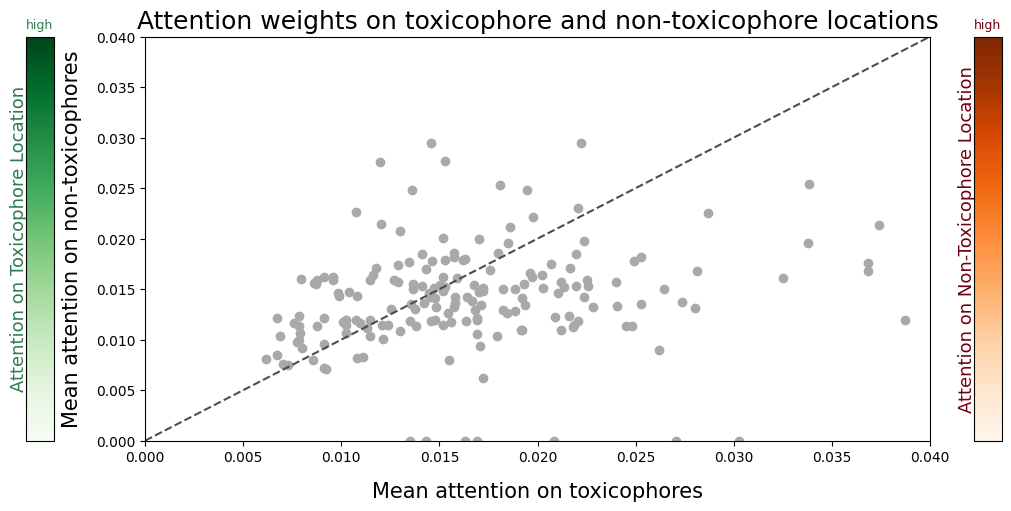

In [7]:
fig = plt.figure(constrained_layout=True, figsize=(10,5))
gs = fig.add_gridspec(1, 30)

    
ax = fig.add_subplot(gs[0, 1:29])
s = 15

ax.set_xlabel('Mean attention on toxicophores', size=s)
ax.xaxis.set_label_coords(0.5, -0.1)

ax.set_ylabel('Mean attention on non-toxicophores', labelpad=10, size=s)
ax.set_title('Attention weights on toxicophore and non-toxicophore locations', size=s+3)
ax.set_xlim((0,0.04))
ax.set_ylim((0,0.04))
points = ax.scatter(tox_mean_atoms_nonatoms, nontox_mean_atoms_nonatoms, c='darkgrey')
ax.plot([0, 0.05], [0, 0.05], ls="--", c=".3")


ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('high', size=9,color='#2d7c4c')#'#043477')
ax1.set_xlabel('low', size = 9,color='#2d7c4c')#'#043477')
cb1 = colorbar.ColorbarBase(ax1, cmap=cm.Greens,
                                ticks=[],
                                orientation='vertical')
cb1.set_label('Attention on Toxicophore Location', size = 13,color='#2d7c4c',#'#043477',
              labelpad=-35)

ax2 = fig.add_subplot(gs[0, 29])
ax2.set_title('high', size=9,color='#71000E')
ax2.set_xlabel('low', size = 9,color='#71000E')
cb2 = colorbar.ColorbarBase(ax2, cmap=cm.Oranges,
                                ticks=[],
                                orientation='vertical')
cb2.set_label('Attention on Non-Toxicophore Location', size = 13,color='#71000E',labelpad=-35)

tooltip = plugins.PointHTMLTooltip(points, svgs)
plugins.connect(fig, tooltip)

open('attention_atoms_nonatoms_green_orange_redone.html', 'w').write(fig_to_html(fig))